<a href="https://colab.research.google.com/github/Andreas-Lukito/Medzy_ocr/blob/rayhan%2FTrOCR/medzy-trocr_colab_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medzy
## Overview
This project aims to develop a machine learning model capable of interpreting doctors’ handwriting on prescriptions. By accurately detecting and translating challenging handwriting, the model will empower patients to read their prescriptions independently, making it easier for them to purchase their medications without confusion if they run out of medicine.

This model is using Hugging Face's [TrOCR](https://huggingface.co/docs/transformers/en/model_doc/trocr) for classifying the handwritings.

The code below is referenced from [TrOCR tutorial notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb) with some changes.

## Get Pytorch Device

### DirectML

In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install transformers

In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00


In [4]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.1 MB/s eta 0:00:00


In [5]:
import torch
# import torch_directml (for windows only)

# device = torch_directml.device()

### CUDA (fallback to CPU if none)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preparing data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
train_path = "/content/drive/MyDrive/project_medzy/dataset/Training"
validation_path = "/content/drive/MyDrive/project_medzy/dataset/Validation"
testing_path = "/content/drive/MyDrive/project_medzy/dataset/Testing"

train_df = pd.read_csv(f"{train_path}/training_labels.csv", delimiter = ",")
val_df = pd.read_csv(f"{validation_path}/validation_labels.csv", delimiter = ",")
test_df = pd.read_csv(f"{testing_path}/testing_labels.csv", delimiter = ",")

In [9]:
train_df

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol
...,...,...,...
3115,3115.png,Zithrin,Azithromycin Dihydrate
3116,3116.png,Zithrin,Azithromycin Dihydrate
3117,3117.png,Zithrin,Azithromycin Dihydrate
3118,3118.png,Zithrin,Azithromycin Dihydrate


Each element of the dataset should return 2 things:

- `pixel_values`, which serve as input to the model.
- `labels`, which are the input_ids of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from input_ids).

In [10]:
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['IMAGE'][idx]
        text = self.df['MEDICINE_NAME'][idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length
        ).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [11]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

train_dataset = IAMDataset(
    root_dir=f"{train_path}/training_words/",
    df=train_df,
    processor=processor
)
eval_dataset = IAMDataset(
    root_dir=f"{validation_path}/validation_words/",
    df=test_df,
    processor=processor
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3120
Number of validation examples: 780


Let's verify an example from the training dataset:

In [13]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

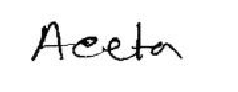

In [14]:
image = Image.open(train_dataset.root_dir + train_df['IMAGE'][0]).convert("RGB")
image

In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Aceta


Let's create corresponding dataloaders:

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Training Model

In [17]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

Importantly, we need to set a couple of attributes, namely:

the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the labels one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
the vocabulary size of the model (for the language modeling head on top of the decoder)
beam-search related parameters which are used when generating text.

In [18]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [19]:
import evaluate

cer_metric = evaluate.load("cer")

In [20]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [21]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader):
        # get the inputs
        for k,v in batch.items():
            batch[k] = v.to(device)

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

    # evaluate
    model.eval()
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))

            # compute metrics
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer

    print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 0: 0.9426611195772122


  0%|          | 0/195 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1528: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Validation CER: 0.06973000290307983


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 1: 0.5177116216566318


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 0.06337088125549663


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 2: 0.5631319379195189


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 0.08044845112152807


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 3: 0.5471508245628613


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 0.03478083881930035


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 4: 0.3607514512271453


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 0.017533694937541092


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 5: 0.45526075349786344


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 1.0695022071945146


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 6: 2.0251886500762057


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 4.221223221223221


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 7: 1.665744093289742


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 1.2322004918158769


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 8: 1.3482494379465397


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 4.781239657778117


  0%|          | 0/780 [00:00<?, ?it/s]

Loss after epoch 9: 1.1778297652036716


  0%|          | 0/195 [00:00<?, ?it/s]

Validation CER: 6.78907543311389


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
